In [1]:
import pandas as pd 
import numpy as np
#impot counter 
from collections import Counter
# import matplotlib
import matplotlib.pyplot as plt
# seaborn import 
import seaborn as sns



from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from ete3 import Tree

from scipy.cluster.hierarchy import linkage, dendrogram, to_tree
from ete3 import Tree, TreeStyle, faces, AttrFace

In [2]:
rank1 = pd.read_csv('kinase_ranked_1.csv')
rank1.head()

Uniprot Primary Accession     Protein Phosphosite     SITE_+/-7_AA ranked_1
0                A0A0B4J1R7  A0A0B4J1R7          T6  __MMATGTPESQARF     AAK1
1                A0A1B0GUI2  A0A1B0GUI2        T185  KTPTLQPTPEVHNGL     AAK1
2                A0A1B0GUI2  A0A1B0GUI2        T763  RRLSSASTGKPPLSV     AAK1
3                    A6H8Y1        BDP1       T2081  EKVKENATPTRNTIS     AAK1
4                    A6NC98       CC88B       T1366  EGREADGTGSPSPAP     AAK1

In [3]:
human = pd.read_csv('Kinase_Substrate_Dataset_human.txt', sep='\t')
human.head()

GENE KINASE KIN_ACC_ID KIN_ORGANISM   SUBSTRATE  SUB_GENE_ID SUB_ACC_ID  \
0  EIF2AK1    HRI     Q9BQI3        human  eIF2-alpha       1965.0     P05198   
1  EIF2AK1    HRI     Q9BQI3        human  eIF2-alpha       1965.0     P05198   
2    PRKCD   PKCD     Q05655        human       HDAC5      10014.0     Q9UQL6   
3    PRKCD   PKCD     Q05655        human  PTPRA iso2       5786.0   P18433-2   
4    PRKCD   PKCD     Q05655        human       Bcl-2        596.0     P10415   

  SUB_GENE SUB_ORGANISM SUB_MOD_RSD  SITE_GRP_ID     SITE_+/-7_AA DOMAIN  \
0   EIF2S1        human         S52       447635  MILLsELsRRRIRsI     S1   
1   EIF2S1        human         S49       450210  IEGMILLsELsRRRI     S1   
2    HDAC5        human        S259       447995  FPLRkTAsEPNLKVR    NaN   
3    PTPRA        human        S204       447612  PLLARSPsTNRKYPP    NaN   
4     BCL2        human         S70       448395  RDPVARtsPLQtPAA    NaN   

  IN_VIVO_RXN IN_VITRO_RXN                       CST_CAT#  
0                        X  3597; 9721; 3398; 5199; 53085  
1                        X                            NaN  
2                        X                           3443  
3           X                                         NaN  
4           X                                  2834; 2827

In [25]:
scop3p = pd.read_csv('UnknownKinaseMotif.txt', sep='\t')
scop3p.head()

KIN_ACC_ID  SUB_ACC_ID  score Family    GENE  UP_POS           +/-7AA
0     Q5S007  A0A0A6YYL3    307   LRRK   LRRK2     365  NSQPEKMSQEPEINK
1     Q5S007  A0A0A6YYL3    307   LRRK   LRRK2     490  EDLLRENSMLREEIA
2     O43318      A0AUZ9    540    MLK  MAP3K7     756  LSRIQNSSRNTARRR
3     O14578      A0AV96    270   DMPK     CIT     453  IPAIGAQYSMFPAAP
4     O14578      A0AV96    270   DMPK     CIT     519  PFQGRPITPVYTVAP

In [4]:
len(set(rank1['ranked_1']).intersection(set(human['GENE'])))

147

In [5]:
len(set(rank1['ranked_1']).intersection(set(human['KINASE'])))

238

In [6]:
need_family = ["ATR", "WNK3", "DNAPK", "NEK11", "PRP4","PKCD"]

In [30]:
def create_pssm(df, kinase_col, sequence_col, limited_family = True, verbose = True):

    #capitalize evreything in the sequence_col column
    df[sequence_col] = df[sequence_col].str.upper()

    # Group by 'KINASE_psp' and combine all sequences into a list
    kinase_sequences = df.groupby(kinase_col)[sequence_col].apply(list)

    # Initialize an empty dictionary to store the Logos for each kinase
    data_store = {}

    # For each kinase, create a position frequency matrix and then a sequence logo
    for kinase, sequences in kinase_sequences.items():
        if kinase not in need_family and limited_family:
            # print(f"kinase {kinase} is not here") 
            continue 
        if verbose: 
            print(f"for {kinase} all the sequences are {kinase_sequences[kinase]}")

        # Combine sequences into a single string for each position
        try: 
            aligned_sequences = [''.join(seq) for seq in zip(*sequences)]
            if len(aligned_sequences) != 15:
                continue
        except:
            continue
        
        # Create a DataFrame where each row corresponds to one position
        position_df = pd.DataFrame([Counter(pos) for pos in aligned_sequences]).fillna(0)
        
        # Normalize the counts to get frequencies
        position_freq_matrix = position_df.div(position_df.sum(axis=0), axis=1)
        
        data_store[kinase] = position_freq_matrix
    # print(data_store)

    return data_store

In [31]:
human['SITE_+/-7_AA'].str.upper()

0        MILLSELSRRRIRSI
1        IEGMILLSELSRRRI
2        FPLRKTASEPNLKVR
3        PLLARSPSTNRKYPP
4        RDPVARTSPLQTPAA
              ...       
13728    QRVLDTSSLTQSAPA
13729    DTSSLTQSAPASPTN
13730    LAQPINFSVSLSNSH
13731    ESSPILTSFELVKVP
13732    THRRMVVSMPNLQDI
Name: SITE_+/-7_AA, Length: 13733, dtype: object

In [32]:
# all_sequences = sorted({c for c in human['SITE_+/-7_AA'].str.upper().str.cat() })
# all_sequences

In [33]:
all_sequences = ['A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y',
 '_']

In [34]:
johnson = create_pssm(rank1, 'ranked_1', 'SITE_+/-7_AA', limited_family = False)

for AAK1 all the sequences are ['__MMATGTPESQARF', 'KTPTLQPTPEVHNGL', 'RRLSSASTGKPPLSV', 'EKVKENATPTRNTIS', 'EGREADGTGSPSPAP', 'EQVANGPTPPPRRQL', 'QNSNSQSTPGSSGQR', 'KDLLFQKSPQNHRPP', 'VETFANKSGQSALYD', 'VILGLLKTPAQYDAS', 'KDLLFQKSPQNHRPP', 'SAGPNSPTGGGGGGG', 'QNSNSQSTPGSSGQR', 'SVIIADQTPTPTRFL', 'IELAKEWTPAGKAKQ', 'GSVVPGSSGVGTPRQ', 'KSITILSTPEGTSAA', 'EPTPAQKTPAKVVYV', 'QNTRLQPTPPIPAPA', 'SPVEAEGTPEPGAEA', 'FSTQGTPSGSPFPSQ', 'ASVAQSRSGPLSPAA', 'HVTTAEGTPGTTDQE', 'RALPSLNTGSSSPRG', 'NDVLAVNTPKDAAQQ', 'SPRTLSPTPSAEGYQ', 'SEVSGSGSGNFGEEG', 'RSVAEQHTPVCSRFS', 'DLLAALPTPPHNQTE', 'ESSPQHPTPPARPRH', 'AAPEPERTPVGQGSW', 'FQRVLESTPNNGYLY', 'AVIKEWGTGRDTLRC', 'SSRLENTTPTQPLTP', 'LARTPSPTPQPTSPQ', '___MADKTPGGSQKA', 'PAPSAQPTPPSASVP', 'LSQAASPTGASRSVR', 'SSSSSSGTPASQLYP', 'LSVRLGPSGSAQCLS', 'VSQISVLSGGKAKCS', 'VVLGKDASGQPIFNA', 'PVPETTPTPPTKTGT', 'MASRKEGTGSTATSS', 'RTQTESSTPPGIPGG', 'VYSAPRSTGPGASLG', 'QVVGRAGTGVDNVDL', 'NSLLSKKTGSPGSPG', 'PPPQPQHTPSPAAPP', '_MSRPSSTGPSANKP', 'PYIVLSGSGKSMNAN',

In [35]:
psp = create_pssm(human, 'KINASE', 'SITE_+/-7_AA', limited_family=False)

for AAK1 all the sequences are ['SQITSQVTGQIGWRR', 'LRVVDEKTKDLIVDQ']
for ADCK5 all the sequences are ['YQPRRRKSVKNGQAE']
for ALK all the sequences are ['TAPGAGHYEDTILKS', 'GHTSNNIYEAVKYSE', 'FGMARDIYRASYYRK', 'RRPGEKTYTQRCRLF', 'RVVACNLYPFVKTVA', 'DPGSAAPYLKTKFIC', 'REDSARVYENVGLMQ', 'LVKGEGLYADPYGLL', 'AFSRVQIYHNPTANS', 'SKRKGHEYTNIKYSL', 'QVPQQPTYVQALFDF']
for ALK1 all the sequences are ['STNHSIGSTQSTPCS', 'ASSESSSTNHSIGST', 'TQSTPCSTSSMA___', 'HSIGSTQSTPCSTSS']
for ALK4 all the sequences are ['PKTYVDLTNEETTDS', 'VDLTNEETTDSTTSK']
for AMPKA1 all the sequences are ['SKLPLTRSHNNFVAI', 'KKVAVVRTPPKSPSS', 'GNPFDSKTEQGPQVD', 'QSIPRSASYPCAAPR', 'SARKRSASADNLTLP', 'RPLARVTSLANLISP', 'QHLRLSTSSGRLLYA', 'YGAQTVRSTMNFKIG', 'DTNSKKQSDTHLEET', 'IVFVRFNSSHGFPVE', 'SSLRPARSVPSIAAA', 'GTATPQRSGSVSNYR', 'VKLSSKLSAVSLRGI', 'RPLSRTQSSPLPQSP', 'LMRRSTVSLLDTYQK', 'HNYKVVVTVHGEIDP', 'TVHQRIASWQNLGAV', 'GAKRVIISAPSADAP', 'CNLSRVDSTTCLFPV', 'VPVARKLSAREQRDC', 'TSRIRTQSFSLQERQ', 'LARRRKATQVGEKTP', 'LHIRSSM

In [36]:
scop3p.columns  

Index(['KIN_ACC_ID', 'SUB_ACC_ID', 'score', 'Family', 'GENE', 'UP_POS',
       '+/-7AA'],
      dtype='object')

In [37]:
scop3p_pssm = create_pssm(scop3p, 'GENE', '+/-7AA', limited_family=False)

for AAK1 all the sequences are ['NVQPPKSSPVVSTVL', 'SGSSSTRTPPTANHP', 'SSTRTPPTANHPVEP', 'ERNILPMTPVWAPVP', 'DLKKLNCSPDSFRCT', 'SPTGGRVSVFQTQLP', 'LRDSRPLSPILHIVK', 'RGGKRAMSDLELRQC', 'AKKKPPPSREKKVTR', 'NSGFDVLYHNMKHGQ', 'KKEKDAESVECPDAD', 'VECPDADSLNIPDVD', 'PDVDEEGYSIKPETN', 'YSSSDSDSEDEEPKK', 'SLDELKVSIGNITLS', 'KVSIGNITLSPAISR', 'SIGNITLSPAISRHS', 'ITLSPAISRHSPVQM', 'SPAISRHSPVQMNRN', 'VQMNRNLSNEELTKS', 'SSSARPTTPLSVGTI', 'KLTSGKLSGINEIPR', 'NEIPRPFSPPVTSNT', 'RPFSPPVTSNTSPPP', 'PFSPPVTSNTSPPPA', 'SPPVTSNTSPPPAAP', 'PPVTSNTSPPPAAPL', 'PLARAESSSSISSSA', 'ARAESSSSISSSASL', 'SSISSSASLSAANTP', 'VGVSRGPSPVSLGNQ', 'VSLGNQDTLPVAVAL', 'HRRVEHGSGLTRTPS', 'VEHGSGLTRTPSSEE', 'HGSGLTRTPSSEEIS', 'SGLTRTPSSEEISPT', 'GLTRTPSSEEISPTK', 'TPSSEEISPTKFPGL', 'SSEEISPTKFPGLYR', 'LYRTGEPSPPHDILH', 'HEPPDVVSDDEKDHG', 'KEKRTEGYAAFQEDS', 'YAAFQEDSSGDEAES', 'AAFQEDSSGDEAESP', 'IHVFKKPSFSKKKEK', 'KIAQEIASLSKEDVS', 'AQEIASLSKEDVSKE', 'GKEPAKPSPSRDRKE', 'MGPERHLSGAPARMA', 'ALQARQASPAWK', 'RDEATILTGMLIGLS', 'T

In [52]:
common_gene = set(scop3p_pssm.keys()).intersection(set(psp.keys())).intersection(set(johnson.keys()))

In [51]:
len(set(scop3p_pssm.keys()).intersection(set(psp.keys())).intersection(set(johnson.keys())))

29

In [38]:
def add_missing_columns(pssm1):
    for col in all_sequences:
        if col not in pssm1.columns:
            pssm1[col] = -1
    return pssm1

In [39]:
columns_to_keep = ['-5P',
 '-5G',
 '-5A',
 '-5C',
 '-5S',
 '-5T',
 '-5V',
 '-5I',
 '-5L',
 '-5M',
 '-5F',
 '-5Y',
 '-5W',
 '-5H',
 '-5K',
 '-5R',
 '-5Q',
 '-5N',
 '-5D',
 '-5E',]

In [59]:
def convert_to_normalize_matrix(df, columns_to_keep, suffix = '', only_common_gene = False, common_gene = common_gene): 
    # Flatten the DataFrame
    flattened_data = {}
    for family_name, df in psp.items():
        if not only_common_gene: 
            df = add_missing_columns(df)
            df['position'] = range(-7, 8)
            df.set_index('position', inplace=True)
            # sort the columns 
            df = df[sorted(df.columns)]
            flattened_df = df.unstack().reset_index()
            flattened_df['feature'] = flattened_df['position'].astype(str) + flattened_df['level_0']
            flattened_df = flattened_df[['feature', 0]].set_index('feature').T
            flattened_data[family_name] = flattened_df
        else:
            if family_name not in common_gene:
                continue
            df = add_missing_columns(df)
            df['position'] = range(-7, 8)
            df.set_index('position', inplace=True)
            # sort the columns 
            df = df[sorted(df.columns)]
            flattened_df = df.unstack().reset_index()
            flattened_df['feature'] = flattened_df['position'].astype(str) + flattened_df['level_0']
            flattened_df = flattened_df[['feature', 0]].set_index('feature').T
            flattened_data[family_name] = flattened_df

    # Concatenate all families into a single DataFrame
    final_df = pd.concat(flattened_data.values(), keys=flattened_data.keys())

    # Reset index to have family names as a column
    final_df.reset_index(level=1, drop=True, inplace=True)
    final_df.reset_index(inplace=True)
    final_df.rename(columns={'index': 'Family'}, inplace=True)
    # add suffix to the Family column
    final_df['Family'] = final_df['Family'] + suffix

    final_df.set_index('Family', inplace=True)
    final_df = final_df[columns_to_keep]

    # drop the feature column 
    # final_df.reset_index( inplace=True)
    # final_df.set_index('Family', inplace=True)
    
    return final_df

In [54]:
convert_to_normalize_matrix(psp, columns_to_keep, suffix='_psp')

feature               -5P       -5G       -5A  -5C       -5S       -5T  \
Family                                                                   
AAK1_psp        -1.000000  0.000000 -1.000000 -1.0  0.000000  0.000000   
ADCK5_psp        1.000000  0.000000  0.000000 -1.0  0.000000 -1.000000   
ALK_psp          0.333333  0.090909  0.000000  0.0  0.100000  0.100000   
ALK1_psp         0.000000  0.000000  0.000000  0.0  0.090909  0.000000   
ALK4_psp         0.000000 -1.000000 -1.000000 -1.0  0.000000  0.111111   
...                   ...       ...       ...  ...       ...       ...   
p70S6K_psp       0.040816  0.034483  0.037736  0.0  0.029412  0.000000   
p70S6K iso2_psp  0.000000  0.142857  0.000000  0.0  0.000000  0.000000   
p90RSK_psp       0.000000  0.029851  0.080645  0.0  0.023585  0.056338   
skMLCK_psp       1.000000 -1.000000 -1.000000 -1.0  0.000000  0.000000   
smMLCK_psp       0.500000  0.000000  0.100000 -1.0  0.000000  0.000000   

feature               -5V       -5I       -5L       -5M  -5F  -5Y  -5W  \
Family                                                                   
AAK1_psp         0.250000  0.333333  0.000000 -1.000000 -1.0 -1.0  0.0   
ADCK5_psp        0.000000 -1.000000 -1.000000 -1.000000 -1.0  0.0 -1.0   
ALK_psp          0.090909  0.000000  0.000000  0.500000  0.0  0.0 -1.0   
ALK1_psp        -1.000000  0.333333 -1.000000  0.000000 -1.0 -1.0 -1.0   
ALK4_psp         0.000000 -1.000000  0.500000 -1.000000 -1.0  0.0 -1.0   
...                   ...       ...       ...       ...  ...  ...  ...   
p70S6K_psp       0.045455  0.000000  0.021739  0.142857  0.0  0.0 -1.0   
p70S6K iso2_psp -1.000000 -1.000000  0.000000 -1.000000  0.0 -1.0 -1.0   
p90RSK_psp       0.000000  0.037037  0.092308  0.043478  0.0  0.0 -1.0   
skMLCK_psp       0.000000  0.000000 -1.000000 -1.000000 -1.0 -1.0 -1.0   
smMLCK_psp       0.000000 -1.000000 -1.000000  0.000000  0.0 -1.0 -1.0   

feature               -5H       -5K       -5R       -5Q   -5N       -5D  \
Family                                                                    
AAK1_psp        -1.000000  0.000000  0.000000  0.000000 -1.00  0.000000   
ADCK5_psp       -1.000000  0.000000  0.000000  0.000000  0.00 -1.000000   
ALK_psp          0.000000  0.090909  0.083333  0.000000  0.00  0.166667   
ALK1_psp         0.000000 -1.000000 -1.000000  0.000000  0.50 -1.000000   
ALK4_psp        -1.000000  0.000000 -1.000000 -1.000000  0.00  0.000000   
...                   ...       ...       ...       ...   ...       ...   
p70S6K_psp       0.076923  0.114286  0.271028  0.050000  0.00  0.076923   
p70S6K iso2_psp -1.000000  0.000000  0.500000  0.000000  0.00 -1.000000   
p90RSK_psp       0.000000  0.109375  0.233766  0.066667  0.04  0.044444   
skMLCK_psp       0.000000 -1.000000  0.000000 -1.000000  0.00  0.000000   
smMLCK_psp      -1.000000  0.000000  0.222222  0.000000  0.00  0.000000   

feature              -5E  
Family                    
AAK1_psp         0.00000  
ADCK5_psp        0.00000  
ALK_psp          0.00000  
ALK1_psp         0.00000  
ALK4_psp         0.00000  
...                  ...  
p70S6K_psp       0.03125  
p70S6K iso2_psp  0.00000  
p90RSK_psp       0.00000  
skMLCK_psp       0.00000  
smMLCK_psp       0.00000  

[416 rows x 20 columns]

In [19]:
data_psp = convert_to_normalize_matrix(psp,columns_to_keep, suffix='_psp')

In [20]:
data_rank1 = convert_to_normalize_matrix(johnson, columns_to_keep, suffix='_johnson')

In [41]:
data_scop3p = convert_to_normalize_matrix(scop3p_pssm, columns_to_keep, suffix='_scop3p')   

In [43]:
# merge the dataframes
data = pd.concat([data_psp, data_rank1, data_scop3p])

In [46]:
data

feature                  -5P       -5G       -5A  -5C       -5S       -5T  \
Family                                                                      
AAK1_psp           -1.000000  0.000000 -1.000000 -1.0  0.000000  0.000000   
ADCK5_psp           1.000000  0.000000  0.000000 -1.0  0.000000 -1.000000   
ALK_psp             0.333333  0.090909  0.000000  0.0  0.100000  0.100000   
ALK1_psp            0.000000  0.000000  0.000000  0.0  0.090909  0.000000   
ALK4_psp            0.000000 -1.000000 -1.000000 -1.0  0.000000  0.111111   
...                      ...       ...       ...  ...       ...       ...   
p70S6K_scop3p       0.040816  0.034483  0.037736  0.0  0.029412  0.000000   
p70S6K iso2_scop3p  0.000000  0.142857  0.000000  0.0  0.000000  0.000000   
p90RSK_scop3p       0.000000  0.029851  0.080645  0.0  0.023585  0.056338   
skMLCK_scop3p       1.000000 -1.000000 -1.000000 -1.0  0.000000  0.000000   
smMLCK_scop3p       0.500000  0.000000  0.100000 -1.0  0.000000  0.000000   

feature                  -5V       -5I       -5L       -5M  -5F  -5Y  -5W  \
Family                                                                      
AAK1_psp            0.250000  0.333333  0.000000 -1.000000 -1.0 -1.0  0.0   
ADCK5_psp           0.000000 -1.000000 -1.000000 -1.000000 -1.0  0.0 -1.0   
ALK_psp             0.090909  0.000000  0.000000  0.500000  0.0  0.0 -1.0   
ALK1_psp           -1.000000  0.333333 -1.000000  0.000000 -1.0 -1.0 -1.0   
ALK4_psp            0.000000 -1.000000  0.500000 -1.000000 -1.0  0.0 -1.0   
...                      ...       ...       ...       ...  ...  ...  ...   
p70S6K_scop3p       0.045455  0.000000  0.021739  0.142857  0.0  0.0 -1.0   
p70S6K iso2_scop3p -1.000000 -1.000000  0.000000 -1.000000  0.0 -1.0 -1.0   
p90RSK_scop3p       0.000000  0.037037  0.092308  0.043478  0.0  0.0 -1.0   
skMLCK_scop3p       0.000000  0.000000 -1.000000 -1.000000 -1.0 -1.0 -1.0   
smMLCK_scop3p       0.000000 -1.000000 -1.000000  0.000000  0.0 -1.0 -1.0   

feature                  -5H       -5K       -5R       -5Q   -5N       -5D  \
Family                                                                       
AAK1_psp           -1.000000  0.000000  0.000000  0.000000 -1.00  0.000000   
ADCK5_psp          -1.000000  0.000000  0.000000  0.000000  0.00 -1.000000   
ALK_psp             0.000000  0.090909  0.083333  0.000000  0.00  0.166667   
ALK1_psp            0.000000 -1.000000 -1.000000  0.000000  0.50 -1.000000   
ALK4_psp           -1.000000  0.000000 -1.000000 -1.000000  0.00  0.000000   
...                      ...       ...       ...       ...   ...       ...   
p70S6K_scop3p       0.076923  0.114286  0.271028  0.050000  0.00  0.076923   
p70S6K iso2_scop3p -1.000000  0.000000  0.500000  0.000000  0.00 -1.000000   
p90RSK_scop3p       0.000000  0.109375  0.233766  0.066667  0.04  0.044444   
skMLCK_scop3p       0.000000 -1.000000  0.000000 -1.000000  0.00  0.000000   
smMLCK_scop3p      -1.000000  0.000000  0.222222  0.000000  0.00  0.000000   

feature                 -5E  
Family                       
AAK1_psp            0.00000  
ADCK5_psp           0.00000  
ALK_psp             0.00000  
ALK1_psp            0.00000  
ALK4_psp            0.00000  
...                     ...  
p70S6K_scop3p       0.03125  
p70S6K iso2_scop3p  0.00000  
p90RSK_scop3p       0.00000  
skMLCK_scop3p       0.00000  
smMLCK_scop3p       0.00000  

[1248 rows x 20 columns]

In [65]:
data.to_csv('PSSM for dendogram.csv')


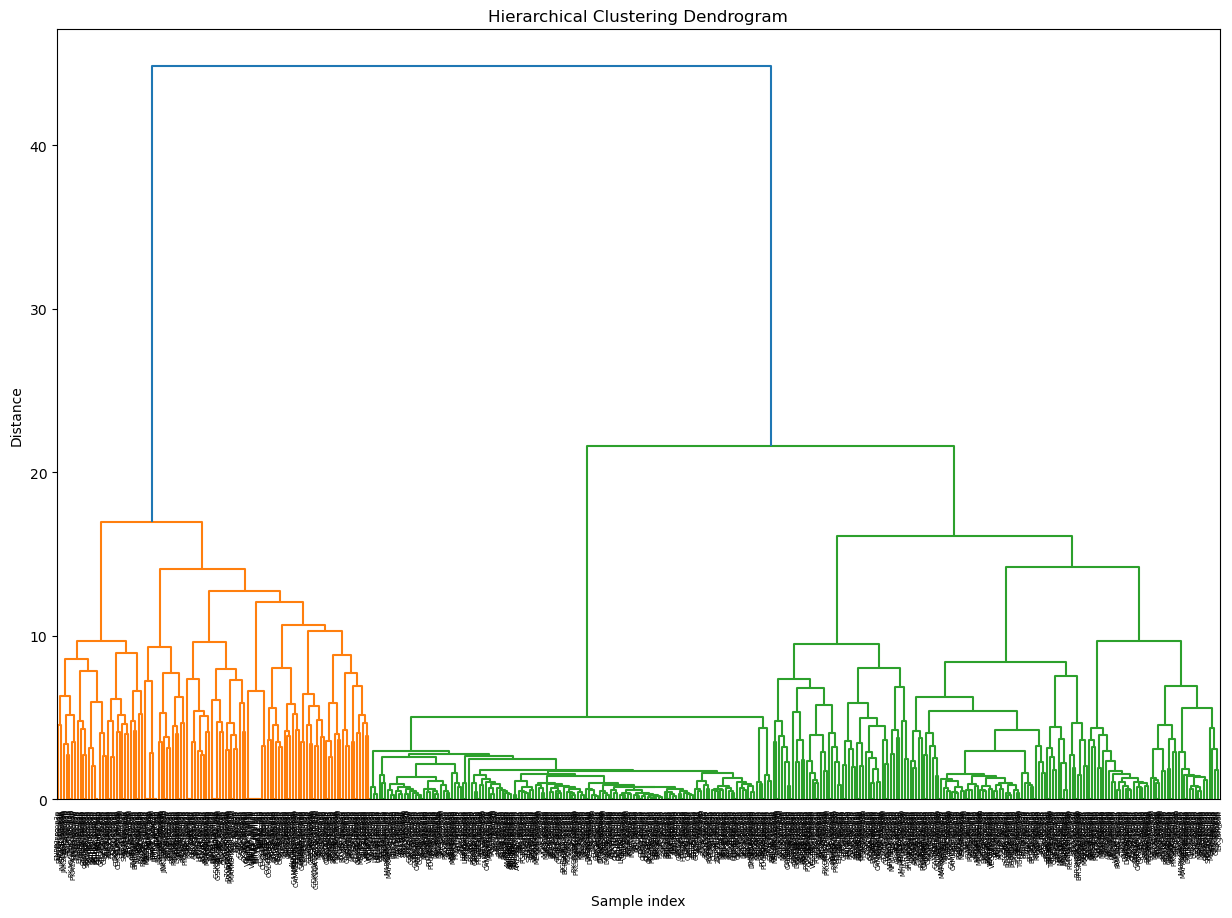

In [44]:
# Compute the linkage matrix using the first 20 columns
linkage_matrix = linkage(data, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, labels=data.index.values)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

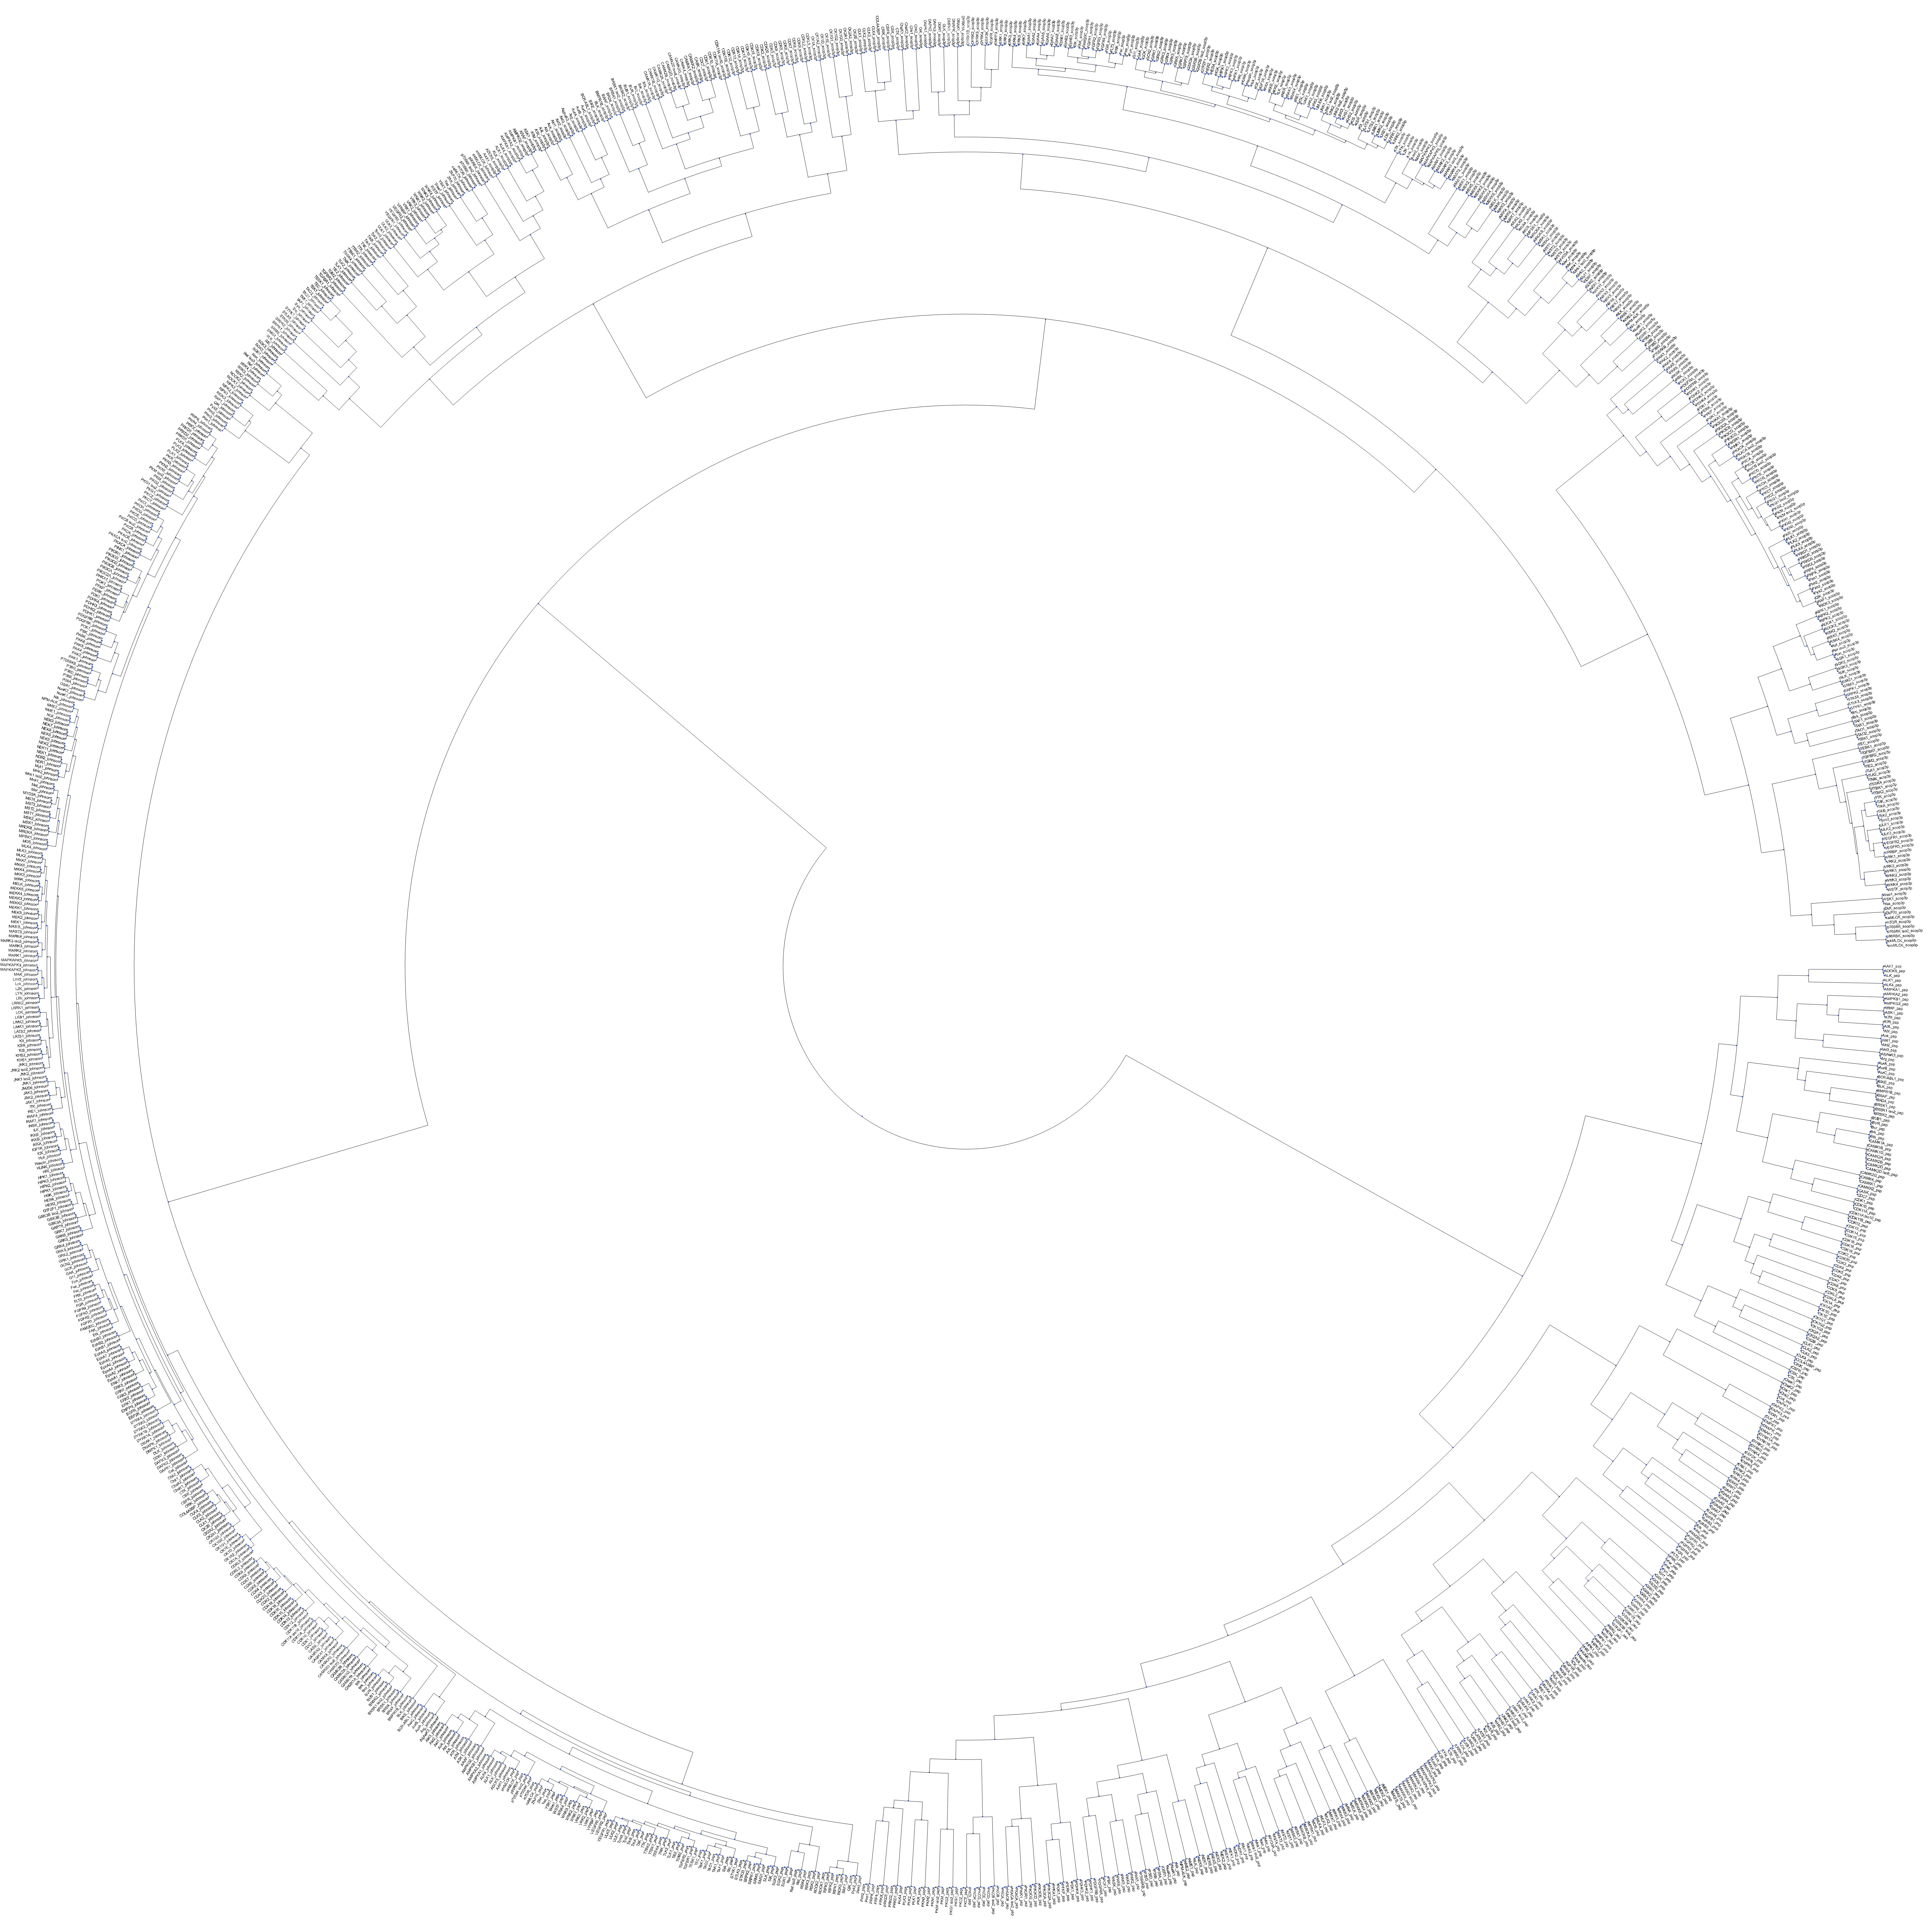

In [45]:

# Ensure the necessary libraries are installed
# !pip install scipy ete3 pandas matplotlib

# Reusing the previously computed linkage_matrix
# linkage_matrix = linkage(data_subset, method='ward') # Already computed

# Convert the linkage matrix to a Newick tree format
def convert_to_newick(linkage_matrix):
    def build_newick(node, parent_dist, leaf_names, newick=''):
        if node.is_leaf():
            return "%s:%f%s" % (leaf_names[node.id], parent_dist - node.dist, newick)
        else:
            if newick == '':
                newick = ');'
            else:
                newick = '):%f%s' % (parent_dist - node.dist, newick)
            newick = build_newick(node.get_right(), node.dist, leaf_names, newick)
            newick = build_newick(node.get_left(), node.dist, leaf_names, ',%s' % (newick))
            newick = '(%s' % (newick)
            return newick

    tree = to_tree(linkage_matrix)
    return build_newick(tree, tree.dist, list(map(str, range(len(data)))))

newick_tree = convert_to_newick(linkage_matrix)

# Load the Newick tree using ete3
t = Tree(newick_tree)

# Add leaf names
for i, leaf in enumerate(t.iter_leaves()):
    leaf.name = data.index.values[i]

# Create a TreeStyle for circular layout
ts = TreeStyle()
ts.mode = "c"
ts.show_leaf_name = True
ts.show_scale = False

# Render the tree
t.render("%%inline", tree_style=ts)


With common gene

In [61]:
data_psp = convert_to_normalize_matrix(psp,columns_to_keep, suffix='_psp', only_common_gene=True)
data_rank1 = convert_to_normalize_matrix(johnson, columns_to_keep, suffix='_johnson', only_common_gene=True)
data_scop3p = convert_to_normalize_matrix(scop3p_pssm, columns_to_keep, suffix='_scop3p', only_common_gene=True)
data = pd.concat([data_psp, data_rank1, data_scop3p])
data


feature          -5P       -5G       -5A       -5C       -5S       -5T  \
Family                                                                   
CAMK1G_psp   -1.0000  0.000000 -1.000000 -1.000000  0.000000  0.000000   
CDK13_psp     0.0000  0.000000  0.000000  0.333333  0.071429  0.000000   
CLK4_psp      0.0000 -1.000000 -1.000000 -1.000000  0.000000  0.000000   
DAPK2_psp     0.0000  0.000000  0.000000  0.000000  0.000000  0.000000   
DYRK4_psp    -1.0000 -1.000000 -1.000000 -1.000000  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
TLK1_scop3p   0.0625  0.000000  0.000000 -1.000000  0.100000  0.000000   
TTBK2_scop3p  0.0000  0.000000  0.285714 -1.000000  0.045455  0.000000   
VRK2_scop3p   0.0000  0.285714  0.000000  0.000000  0.000000  0.000000   
WNK3_scop3p   0.0000  0.000000  0.333333 -1.000000  0.000000  0.000000   
WNK4_scop3p   0.0000  0.000000  0.500000  0.000000  0.000000  0.111111   

feature            -5V  -5I       -5L  -5M  -5F       -5Y  -5W  -5H     -5K  \
Family                                                                        
CAMK1G_psp   -1.000000 -1.0  0.000000  0.0  1.0 -1.000000 -1.0 -1.0  0.0000   
CDK13_psp    -1.000000 -1.0 -1.000000 -1.0  0.0  0.000000 -1.0 -1.0 -1.0000   
CLK4_psp      0.000000 -1.0  0.000000 -1.0 -1.0 -1.000000  0.0 -1.0 -1.0000   
DAPK2_psp     0.000000  0.0  0.000000 -1.0  0.0  0.000000  0.0 -1.0  0.0000   
DYRK4_psp     0.000000  0.0 -1.000000 -1.0  0.0  0.000000 -1.0  0.0  0.0000   
...                ...  ...       ...  ...  ...       ...  ...  ...     ...   
TLK1_scop3p   0.000000  0.0  0.187500 -1.0  0.0  0.000000 -1.0  0.0  0.1250   
TTBK2_scop3p  0.333333  0.0  0.500000 -1.0  0.0  0.000000 -1.0  0.0  0.0000   
VRK2_scop3p   0.000000  0.0  0.181818  0.0  0.0  0.250000 -1.0  0.0  0.0625   
WNK3_scop3p   0.000000  0.0  0.000000  0.0  0.0  0.250000  0.0  0.0  0.0000   
WNK4_scop3p   0.000000  0.0  0.500000  0.0  0.0  0.333333 -1.0  0.2  0.0000   

feature            -5R   -5Q       -5N  -5D       -5E  
Family                                                 
CAMK1G_psp    0.000000 -1.00  0.000000  0.0 -1.000000  
CDK13_psp     0.000000  1.00 -1.000000  0.0  0.000000  
CLK4_psp      0.000000  0.00 -1.000000  0.0  1.000000  
DAPK2_psp     0.333333 -1.00  0.000000 -1.0 -1.000000  
DYRK4_psp     0.000000  0.50 -1.000000 -1.0  0.000000  
...                ...   ...       ...  ...       ...  
TLK1_scop3p   0.000000  0.25  0.166667  0.0  0.000000  
TTBK2_scop3p  0.000000  0.00  0.000000  0.0  0.136364  
VRK2_scop3p   0.100000  0.00  0.000000  0.0  0.181818  
WNK3_scop3p   0.000000  0.00  0.000000  0.5  0.166667  
WNK4_scop3p   0.000000 -1.00  0.000000  0.0  0.000000  

[87 rows x 20 columns]

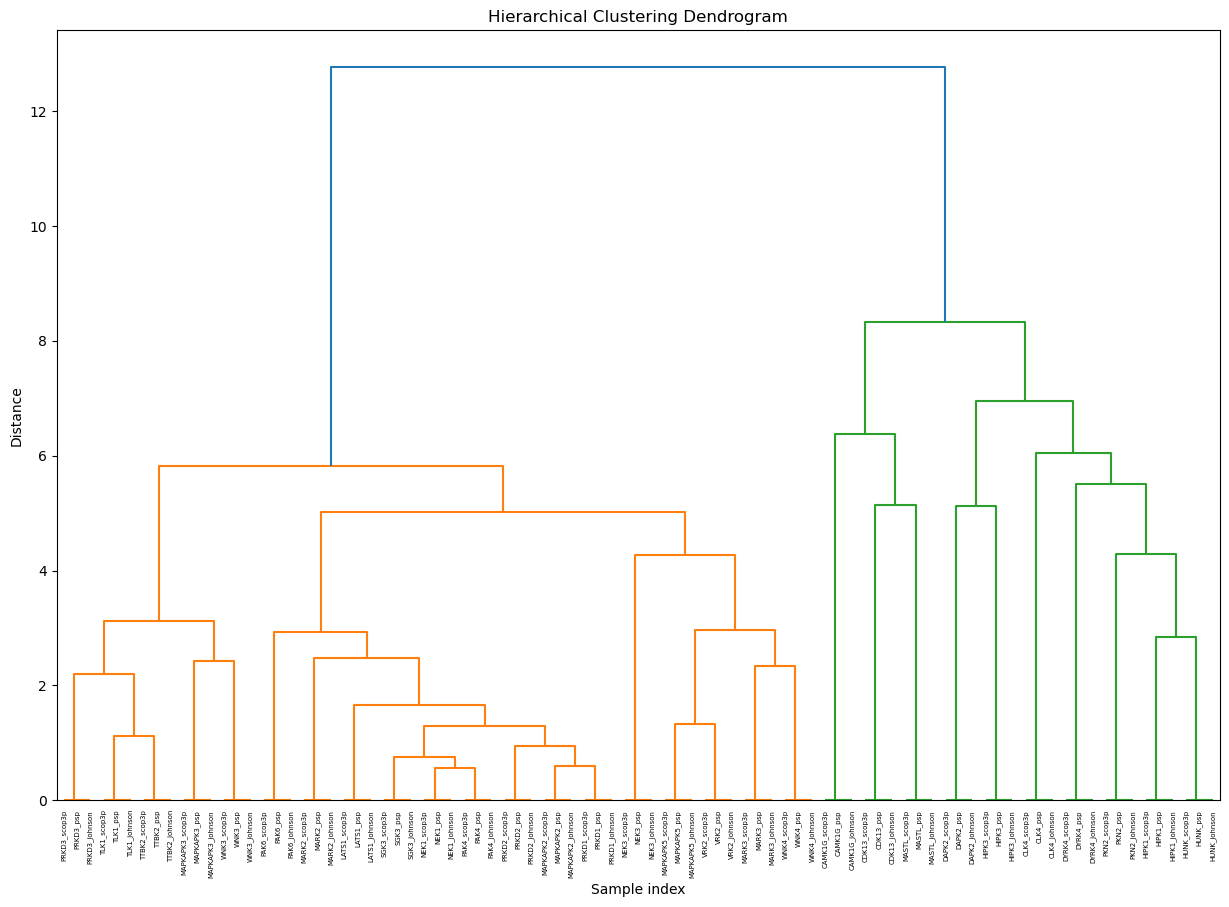

In [62]:
# Compute the linkage matrix using the first 20 columns
linkage_matrix = linkage(data, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, labels=data.index.values)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

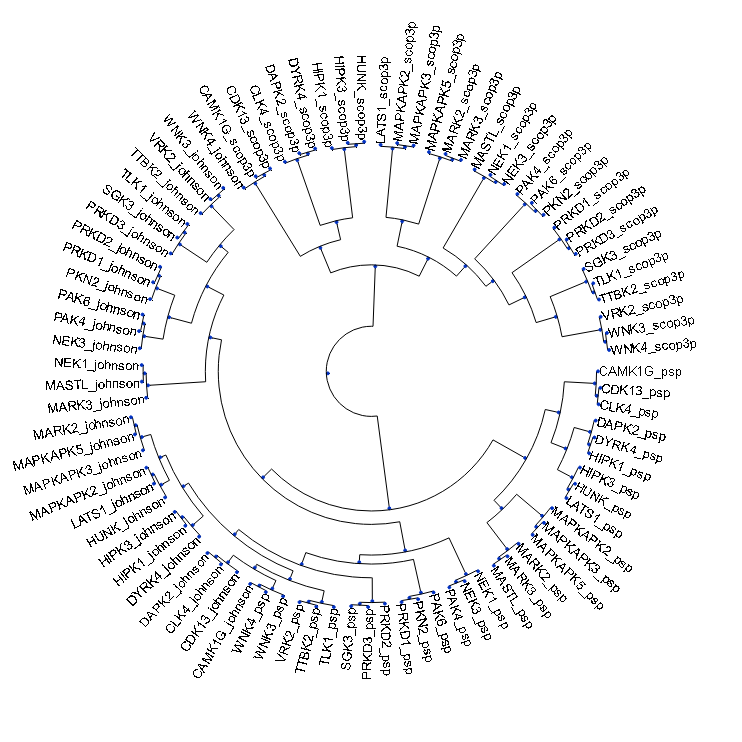

In [63]:
# Ensure the necessary libraries are installed
# !pip install scipy ete3 pandas matplotlib

# Reusing the previously computed linkage_matrix
# linkage_matrix = linkage(data_subset, method='ward') # Already computed

# Convert the linkage matrix to a Newick tree format
def convert_to_newick(linkage_matrix):
    def build_newick(node, parent_dist, leaf_names, newick=''):
        if node.is_leaf():
            return "%s:%f%s" % (leaf_names[node.id], parent_dist - node.dist, newick)
        else:
            if newick == '':
                newick = ');'
            else:
                newick = '):%f%s' % (parent_dist - node.dist, newick)
            newick = build_newick(node.get_right(), node.dist, leaf_names, newick)
            newick = build_newick(node.get_left(), node.dist, leaf_names, ',%s' % (newick))
            newick = '(%s' % (newick)
            return newick

    tree = to_tree(linkage_matrix)
    return build_newick(tree, tree.dist, list(map(str, range(len(data)))))

newick_tree = convert_to_newick(linkage_matrix)

# Load the Newick tree using ete3
t = Tree(newick_tree)

# Add leaf names
for i, leaf in enumerate(t.iter_leaves()):
    leaf.name = data.index.values[i]

# Create a TreeStyle for circular layout
ts = TreeStyle()
ts.mode = "c"
ts.show_leaf_name = True
ts.show_scale = False

# Render the tree
t.render("%%inline", tree_style=ts)
